# **Is the NBA Becoming a More Global Product: An Analysis of NBA Player Distribution and Trends**

**Introduction**

This project explores the globalisation of the NBA by analysing advanced statistics, player distribution, and trends over time. Using advanced metrics, each player is assigned a composite score to quantify their performance for a given season. By filtering for the top 10 NBA players over the past three seasons based on this composite score, this study aims to evaluate whether globalisation is permeating the league’s elite ranks. Furthermore, this project examines player distributions by nationality over the same period to assess the broader impact of globalisation on the league.

**Key Questions:**
1. Who are the top 10 players in the NBA based on performance over the past three seasons?
2. How has the distribution of NBA players by nationality evolved over the same period?

This analysis leverages data from two primary sources:
- **[Basketball-Reference.com](https://www.basketball-reference.com):** A widely respected resource for historical and current NBA data, providing comprehensive player statistics and advanced metrics.
- **[NBA API](https://developer.nba.com/):** An official source of real-time league data, offering up-to-date player metrics and team statistics for robust and accurate analysis.

By examining these questions and trends, this study seeks to uncover whether the influx of international players is reshaping the league and determine if these players are competing at the highest levels of basketball excellence.

## **Import necessary modules**

Begin by importing the necessary libraries for data manipulation, API calls, and visualisations

In [28]:
import pandas as pd
import numpy as np
import time
import requests
import os 
import sys
import logging
from bs4 import BeautifulSoup
from io import StringIO, BytesIO
from unidecode import unidecode
import unicodedata
from nba_api.stats.endpoints import leaguedashplayerstats, commonplayerinfo
from nba_api.stats.library.parameters import SeasonTypeAllStar
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
from psycopg2 import OperationalError
from sqlalchemy import create_engine
from sklearn.preprocessing import MinMaxScaler
from PIL import Image, ImageDraw

pd.set_option('display.max_columns', None)

## **Read Environment Variables from Config File**

In [29]:
# Load environment variables manually
env_file = "config.env"
if os.path.exists(env_file):
    with open(env_file) as f:
        for line in f:
            key, value = line.strip().split("=")
            os.environ[key] = value  # Store in environment


## **1. Data Collection**

### Basketball-Reference Data Scraping

This data includes a player's:  

| **Label**                       | **Description**                                                                 |
|----------------------------------|---------------------------------------------------------------------------------|
| Name                        | Full name                                                                      |
| Team                        | 3-letter team label (e.g. LAL)                                                 |
| Season                      | NBA season (e.g. "2023-24")                                                    |
| Games Played                | Number of games played in the season                                           |
| Player Efficiency Rating (PER) | A per-minute rating summarising accomplishments, adjusted for pace; avg = 15   |
| True Shooting Percentage (TS%) | Accounts for field goals, three-point shots, and free throws                   |
| Usage Percentage (USG%)     | Percentage of team plays used, including FG attempts, FT attempts, and turnovers |
| Win Shares per 48 Minutes (WS/48)| Contribution to team wins, normalised to 48 minutes; league avg = 0.100       |
| Box Plus/Minus (BPM)        | Impact on team's performance per 100 possessions compared to a league-average player |
| Value Over Replacement (VORP) | Contribution above replacement-level player, scaled per season                 |

In [30]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


def transliterate_name(name: str) -> str:
    """
    Ensures names are alphabetic and free of special characters or accents.
    """
    if isinstance(name, str):
        name = unicodedata.normalize("NFKD", name)
        name = unidecode(name)
        name = ''.join(c for c in name if c.isalpha() or c.isspace()).strip()
    return name


def ensure_folder_exists(folder_path: str) -> None:
    """
    Ensures the specified folder exists.
    """
    os.makedirs(folder_path, exist_ok=True)


def scrape_save_stats(season: str, folder_path: str) -> str:
    """
    Scrapes advanced stats from Basketball-Reference for a given season and saves HTML files.
    Returns the file path of the saved HTML.
    """
    ensure_folder_exists(folder_path)
    file_name = f"bball_ref_20{season.split('-')[1]}.html"
    file_path = os.path.join(folder_path, file_name)

    if not os.path.exists(file_path):
        logging.info(f"Scraping data for the {season} season...")
        url = f"https://www.basketball-reference.com/leagues/NBA_20{season.split('-')[1]}_advanced.html"
        response = requests.get(url)
        response.encoding = 'utf-8'
        response.raise_for_status()

        with open(file_path, "w", encoding="utf-8") as f:
            f.write(response.text)
        logging.info(f"File saved: {file_path}")
    else:
        logging.info(f"Data already saved for {season} season.")

    return file_path


def parse_and_clean(file_path: str) -> pd.DataFrame:
    """
    Parses an HTML file, extracts and cleans the advanced stats table, and returns a DataFrame.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        page = f.read()

    soup = BeautifulSoup(page, "html5lib")
    table = soup.find("table", {"id": "advanced"})
    if not table:
        raise ValueError(f"No table found in file: {file_path}")

    df = pd.read_html(StringIO(str(table)))[0]
    df = df[df["Player"] != "Player"]  # Remove duplicate headers
    df = df[["Player", "Team", "G", "PER", "TS%", "USG%", "WS/48", "BPM", "VORP"]]
    df.columns = ["player", "team", "games_played", "per", "ts", "usg", "ws_48", "bpm", "vorp"]
    df["player"] = df["player"].str.strip().apply(transliterate_name)

    return df


def collect_scraped_data(seasons: list[str], folder_path: str) -> pd.DataFrame:
    """
    Collects and compiles scraped advanced stats data for the specified seasons.
    """
    all_stats = []
    for season in seasons:
        try:
            file_path = scrape_save_stats(season, folder_path)
            season_data = parse_and_clean(file_path)
            season_data["season"] = season
            all_stats.append(season_data)
        except Exception as e:
            logging.error(f"Error processing data for {season}: {e}")

    if not all_stats:
        raise ValueError("No valid data collected for any season.")

    return pd.concat(all_stats, ignore_index=True)


last_3_seasons = ["2023-24", "2022-23", "2021-22"]
folder_path = "./data/bball_ref"

bball_ref_df = collect_scraped_data(last_3_seasons, folder_path)

logging.info("Data collection and cleaning completed.")


2025-01-21 15:26:18,036 - INFO - Data already saved for 2023-24 season.
2025-01-21 15:26:19,669 - INFO - Data already saved for 2022-23 season.
2025-01-21 15:26:21,254 - INFO - Data already saved for 2021-22 season.
2025-01-21 15:26:23,068 - INFO - Data collection and cleaning completed.


### **NBA API Data Collection**

This data includes two advanced statistics not collected by Basketball-Reference:
- **Offensive Rating:** An estimate of the number of points a player produces per 100 possessions, including scoring as well as contributions through assists and other factors
- **Defensive Rating:** An estimate of the number of points a player allows per 100 possessions, measuring their defensive impact

It also includes a player's **nationality** and **minutes played per game**

In [31]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def ensure_folder_exists(folder_path: str) -> None:
    """Ensures the specified folder exists."""
    try:
        os.makedirs(folder_path, exist_ok=True)
        logging.info(f"Folder checked/created: {folder_path}")
    except Exception as e:
        logging.error(f"Error ensuring folder exists: {e}")
        raise

def load_nationality_cache(nationality_filepath: str) -> dict:
    """Loads the nationality cache from a CSV file if it exists."""
    if os.path.exists(nationality_filepath):
        try:
            nationality_df = pd.read_csv(nationality_filepath)
            logging.info(f"Loaded player nationalities from cache: {len(nationality_df)} players.")
            return nationality_df.set_index("player_id")["nationality"].to_dict()
        except Exception as e:
            logging.error(f"Error loading nationality cache: {e}")
            return {}
    logging.info("No nationality cache found; starting fresh.")
    return {}

def save_nationality_cache(nationality_filepath: str, new_nationalities: list[dict]) -> None:
    """Saves the updated nationality cache to a CSV file."""
    if new_nationalities:
        try:
            new_nationalities_df = pd.DataFrame(new_nationalities)
            if os.path.exists(nationality_filepath):
                cached_nationalities = pd.read_csv(nationality_filepath)
                new_nationalities_df = pd.concat(
                    [cached_nationalities, new_nationalities_df], ignore_index=True
                ).drop_duplicates()
            new_nationalities_df.to_csv(nationality_filepath, index=False)
            logging.info(f"Updated player nationalities saved to {nationality_filepath}.")
        except Exception as e:
            logging.error(f"Error saving nationality cache: {e}")
            raise

def fetch_season_stats(season: str, season_filepath: str) -> pd.DataFrame:
    """Fetches and saves advanced stats for a given season."""
    if os.path.exists(season_filepath):
        logging.info(f"Loading data for season {season} from cache.")
        return pd.read_csv(season_filepath)

    logging.info(f"Fetching data for season {season}...")
    try:
        stats = leaguedashplayerstats.LeagueDashPlayerStats(
            season=season,
            season_type_all_star=SeasonTypeAllStar.regular,
            measure_type_detailed_defense="Advanced",
            per_mode_detailed="PerGame"
        ).get_data_frames()[0]

        # Keep only relevant columns
        stats = stats[["PLAYER_ID", "PLAYER_NAME", "TEAM_ABBREVIATION", "GP", "MIN", "OFF_RATING", "DEF_RATING"]]
        stats.columns = ["player_id", "player", "team", "games_played", "min", "off_rating", "def_rating"]
        stats["season"] = season

        # Save to CSV
        stats.to_csv(season_filepath, index=False)
        logging.info(f"Season {season} data saved to {season_filepath}.")
        return stats
    except Exception as e:
        logging.error(f"Error fetching data for season {season}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on failure

def fetch_player_nationalities(unique_player_ids: set, player_nationality_cache: dict) -> list[dict]:
    """Fetches nationalities for unique player IDs and updates the cache."""
    new_nationalities = []

    for player_id in unique_player_ids:
        if player_id not in player_nationality_cache:
            try:
                player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id).get_data_frames()[0]
                nationality = player_info.loc[0, "COUNTRY"]
                player_nationality_cache[player_id] = nationality
                new_nationalities.append({"player_id": player_id, "nationality": nationality})
                logging.info(f"Fetched nationality for player ID {player_id}: {nationality}")
                time.sleep(1)  # Avoid hitting rate limits
            except Exception as e:
                logging.error(f"Error fetching nationality for player ID {player_id}: {e}")
                player_nationality_cache[player_id] = "unknown"
                new_nationalities.append({"player_id": player_id, "nationality": "unknown"})

    return new_nationalities

def fetch_advanced_stats_with_nationality(seasons: list[str], folder_path: str) -> pd.DataFrame:
    """
    Fetches advanced stats and player nationalities, saves data to avoid redundant API calls.
    """
    ensure_folder_exists(folder_path)
    nationality_filepath = os.path.join(folder_path, "player_nationality.csv")
    player_nationality_cache = load_nationality_cache(nationality_filepath)

    all_stats = []
    unique_player_ids = set()

    for season in seasons:
        season_filepath = os.path.join(folder_path, f"nba_stats_{season.replace('-', '_')}.csv")
        season_stats = fetch_season_stats(season, season_filepath)
        if not season_stats.empty:
            all_stats.append(season_stats)
            unique_player_ids.update(season_stats["player_id"].unique())
        time.sleep(2)  # Avoid hitting rate limits

    new_nationalities = fetch_player_nationalities(unique_player_ids, player_nationality_cache)
    save_nationality_cache(nationality_filepath, new_nationalities)

    if not all_stats:
        logging.error("No data was fetched for the specified seasons.")
        raise ValueError("No data was fetched for the specified seasons.")

    combined_stats = pd.concat(all_stats, ignore_index=True)
    combined_stats["nationality"] = combined_stats["player_id"].map(player_nationality_cache)

    return combined_stats

# Execution logic for the notebook
last_3_seasons = ["2023-24", "2022-23", "2021-22"]
folder_path = "./data/nba_api"

nba_api_df = fetch_advanced_stats_with_nationality(last_3_seasons, folder_path)
nba_api_df["player"] = nba_api_df["player"].str.strip().apply(transliterate_name)

logging.info("Data fetching complete.")


2025-01-21 15:26:23,081 - INFO - Folder checked/created: ./data/nba_api
2025-01-21 15:26:23,083 - INFO - Loaded player nationalities from cache: 818 players.
2025-01-21 15:26:23,084 - INFO - Loading data for season 2023-24 from cache.
2025-01-21 15:26:25,087 - INFO - Loading data for season 2022-23 from cache.
2025-01-21 15:26:27,089 - INFO - Loading data for season 2021-22 from cache.
2025-01-21 15:26:29,094 - INFO - Data fetching complete.


**Sample Data for Basketball-Reference Data**

```python
bball_ref_df.head()


	player	team	games_played	per	ts	usg	ws_48	bpm	vorp	season
0	DeMar DeRozan	CHI	79.0	19.7	0.584	25.8	0.147	1.8	2.8	2023-24
1	Domantas Sabonis	SAC	82.0	23.2	0.637	22.2	0.206	6.5	6.2	2023-24
2	Coby White	CHI	79.0	14.5	0.570	22.7	0.078	-0.7	0.9	2023-24
3	Mikal Bridges	BRK	82.0	14.9	0.560	24.3	0.070	-0.4	1.2	2023-24
4	Paolo Banchero	ORL	80.0	17.3	0.546	29.7	0.090	1.3	2.3	2023-24
```

**Sample Data for NBA API Data**

```python
nba_api_df.head()

player	team	games_played	min	off_rating	def_rating	season	nationality
0	A.J. Lawson	DAL	42	7.4	106.6	105.3	2023-24	Canada
1	AJ Green	MIL	56	11.0	114.0	110.5	2023-24	USA
2	AJ Griffin	ATL	20	8.5	106.0	120.1	2023-24	USA
3	Aaron Gordon	DEN	73	31.5	119.8	111.1	2023-24	USA
4	Aaron Holiday	HOU	78	16.3	110.5	107.6	2023-24	USA
```

## **2. Data Cleaning**

The data cleaning process involves the following steps:

- **Handling Missing Values:**  
  Records with missing values are either dropped or imputed using weighted averages to ensure data completeness and reliability.

- **Data Alignment:**  
  Aligning Basketball-Reference data with NBA API data is critical for seamless merging downstream. Key differences addressed include:  
  - **Players on Multiple Teams:**  
    - NBA API data provides aggregated records for players who played for multiple teams in a season.  
    - Basketball-Reference data includes both aggregated records and individual team records for such players.
    - NBA API data records the team a player last played for during the season in the aggregated record. In contrast, Basketball-Reference uses custom labels, such as `"3TM"`, to indicate that a player participated for three different teams in a single season.
  - **Team Labels:**  
    - Team labels differ between the datasets for certain teams (e.g., Brooklyn Nets recorded as `BRK` in Basketball-Reference and `BKN` in the NBA API).  

These adjustments ensure consistency across datasets and facilitate accurate analysis in subsequent steps.

### **Missing Values: Basketball-Reference Data**

In [32]:
bball_ref_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2229 entries, 0 to 2228
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        2229 non-null   object 
 1   team          2226 non-null   object 
 2   games_played  2226 non-null   float64
 3   per           2226 non-null   float64
 4   ts            2205 non-null   float64
 5   usg           2229 non-null   float64
 6   ws_48         2226 non-null   float64
 7   bpm           2226 non-null   float64
 8   vorp          2226 non-null   float64
 9   season        2229 non-null   object 
dtypes: float64(7), object(3)
memory usage: 174.3+ KB


The `bball_ref_df` dataframe contains 2,229 rows and 10 columns. It includes missing values in the following columns: `team`, `games_played`, `per`, `ts`, `ws_48`, `bpm`, and `vorp`. The data types of each column appear to be appropriate for analysis.

To handle missing values, I plan to impute them using a weighted average based on the total number of games played. The imputation process will follow these steps:

1. **Single Record Players:**  
   Players with only one record across all seasons (i.e., those who played for a single team in only one season) will be removed from the dataset.

2. **Players on Multiple Teams in a Single Season:**  
   For players who played for multiple teams in one season, missing values will be imputed using a weighted average, calculated based on the number of games played for each team during that season.

3. **Players with Mixed Records:**  
   For players with missing data in single-team seasons who also played for multiple teams in other season(s), the missing values will be imputed using a weighted average across all their seasons. Any imputed values from step 2 (for multi-team seasons) will be incorporated into this calculation when necessary.


In [33]:
def find_multi_team_players(df: pd.DataFrame) -> pd.DataFrame:
    """
    Finds and returns rows for players who played for multiple teams in one season.
    """
    multi_team_check = df.groupby(['player', 'season'], as_index=False)['team'].nunique().query('team > 1')
    multi_team_players = df[
        df.set_index(['player', 'season']).index.isin(multi_team_check.set_index(['player', 'season']).index)
    ]
    return multi_team_players


def impute_weighted_avg(df: pd.DataFrame, numeric_cols: list, group_by: list) -> pd.DataFrame:
    """
    Imputes missing numeric values using a weighted average based on games played.
    """
    if 'games_played' not in df.columns:
        raise KeyError("'games_played' column is missing from the DataFrame.")
        
    grouped = df.groupby(group_by)

    for col in numeric_cols:
        if col in df.columns and df[col].isnull().any():
            print(f"Imputing column: {col}")
            df.loc[:, col] = grouped.apply(
                lambda group: group[col].fillna(
                    (group['games_played'] * group[col]).sum() / group['games_played'].sum()
                    if group['games_played'].sum() > 0 else group[col].mean()
                ), include_groups=False
            ).reset_index(level=group_by, drop=True)

    return df


def update_with_imputed_records(original_df: pd.DataFrame, imputed_df: pd.DataFrame, numeric_cols: list) -> pd.DataFrame:
    """
    Updates the original DataFrame with imputed data for numeric columns.
    """
    original_df = original_df.merge(
        imputed_df[['player', 'season', 'team'] + numeric_cols],
        on=['player', 'season', 'team'],
        how='left',
        suffixes=('', '_imputed')
    )
    for col in numeric_cols:
        imputed_col = f'{col}_imputed'
        if imputed_col in original_df.columns:
            original_df[col] = original_df[imputed_col].where(original_df[imputed_col].notnull(), original_df[col])
            original_df.drop(columns=[imputed_col], inplace=True)


    return original_df


def drop_and_impute(df: pd.DataFrame) -> pd.DataFrame:
    """
    Drops certain records, imputes missing values for multi-team players,
    imputes across seasons, and adds aggregated records back.
    """
    # Step 1: Remove Single-Season Players and Records with Missing Games Played
    single_record_players = df.groupby(['player'], as_index=False)['season'].nunique().query('season == 1')
    print(f"Total number of players that only played one season: {single_record_players.shape[0]} players")
    clean_df = df[~df['player'].isin(single_record_players['player'])]
    print(f"Total rows after removing single-season players: {clean_df.shape[0]} rows")

    clean_df = clean_df[clean_df['games_played'].notnull()]
    print(f"Total rows after removing records with missing games played: {clean_df.shape[0]} rows")

    # Separate aggregate rows from non-aggregate rows
    agg_records = clean_df[clean_df['team'].str.contains(r'^\dTM$', na=False)]
    non_agg_records = clean_df[~clean_df['team'].str.contains(r'^\dTM$', na=False)]
    print(f"Aggregated records: {agg_records.shape[0]} rows")
    print(f"Non-aggregated records: {non_agg_records.shape[0]} rows")

    # Step 2: Perform Imputations
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Impute for Multi-Team Players
    multi_team_players = find_multi_team_players(non_agg_records)
    print("Columns in multi_team_players:", multi_team_players.columns)
    imputed_multi_df = impute_weighted_avg(multi_team_players, numeric_cols, group_by=['player', 'season'])

    # Update Non-Aggregated Records with Imputed Multi-Team Player Data
    non_agg_records = update_with_imputed_records(non_agg_records, imputed_multi_df, numeric_cols)

    # Impute Across Seasons for All Players
    final_imputed_df = impute_weighted_avg(non_agg_records, numeric_cols, group_by=['player'])

    # Update Non-Aggregated Records with Season-Level Imputations
    non_agg_records = update_with_imputed_records(non_agg_records, final_imputed_df, numeric_cols)

    # Step 3: Add Aggregated Records Back
    final_df = pd.concat([non_agg_records, agg_records], ignore_index=True)
    print("Missing values have been dropped or imputed.")

    # Debug: Check for Remaining Missing Values
    print("Final DataFrame missing values:\n", final_df.isnull().sum())

    return final_df


In [34]:
bball_imputed_df = drop_and_impute(bball_ref_df)

Total number of players that only played one season: 288 players
Total rows after removing single-season players: 1850 rows
Total rows after removing records with missing games played: 1847 rows
Aggregated records: 202 rows
Non-aggregated records: 1645 rows
Columns in multi_team_players: Index(['player', 'team', 'games_played', 'per', 'ts', 'usg', 'ws_48', 'bpm',
       'vorp', 'season'],
      dtype='object')
Imputing column: ts
Imputing column: ts
Missing values have been dropped or imputed.
Final DataFrame missing values:
 player          0
team            0
games_played    0
per             0
ts              0
usg             0
ws_48           0
bpm             0
vorp            0
season          0
dtype: int64


### **Missing Values: NBA API Data**

In [35]:
nba_api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716 entries, 0 to 1715
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     1716 non-null   int64  
 1   player        1716 non-null   object 
 2   team          1716 non-null   object 
 3   games_played  1716 non-null   int64  
 4   min           1716 non-null   float64
 5   off_rating    1716 non-null   float64
 6   def_rating    1716 non-null   float64
 7   season        1716 non-null   object 
 8   nationality   1716 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 120.8+ KB


There are 1716 rows and 8 columns. There are no missing values and the datatype of each column is appropriate. Records for players who only played for one season are dropped.

In [36]:
nba_dropped_df = drop_and_impute(nba_api_df)

Total number of players that only played one season: 288 players
Total rows after removing single-season players: 1428 rows
Total rows after removing records with missing games played: 1428 rows
Aggregated records: 0 rows
Non-aggregated records: 1428 rows
Columns in multi_team_players: Index(['player_id', 'player', 'team', 'games_played', 'min', 'off_rating',
       'def_rating', 'season', 'nationality'],
      dtype='object')
Missing values have been dropped or imputed.
Final DataFrame missing values:
 player_id       0
player          0
team            0
games_played    0
min             0
off_rating      0
def_rating      0
season          0
nationality     0
dtype: int64


### **Data Alignment: Aggregate Record Team Labels**

One key difference between the two datasets is how records for players who played for multiple teams in one season are recorded. Basketball-reference provides both aggregated data and individual stats for each team. The NBA API dataset only provides aggregated record. Furthermore, while they both provide aggregated records, Basketball-Reference uses a digit followed by TM to describe the total number of teams the player was on in that season. The NBA API simply inputs the last team they played for in that season. We will align the Basketball-Reference dataset to the NBA API dataset.

In [37]:
def clean_multi_team_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handles players who played for multiple teams by assigning the team label
    based on the last occurrence in the records for a single season.

    Args:
        df (pd.DataFrame): Input DataFrame with columns including 'player', 'season',
                           'team', and 'games_played'.

    Returns:
        pd.DataFrame: Cleaned DataFrame with multi-team players assigned the label
                      of the team appearing last in the records for the season.
    """
    # Separate multi-team players
    aggregate_records_mask = df['team'].str.contains(r'^\dTM$', na=False)
    aggregate_records = df[aggregate_records_mask].copy()

    # Identify the team for multi-team players based on the last occurrence
    last_team_mapping = (
        df[~aggregate_records_mask]
        .groupby(['player', 'season'], group_keys=False, as_index=False)
        .tail(1)[['player', 'season', 'team']]  # Use tail(1) to get the last row per group
        .rename(columns={'team': 'last_team'})
    )

    # Create mapping
    mapping = last_team_mapping.set_index(['player', 'season'])['last_team'].to_dict()

    # Map and replace team labels
    aggregate_records['team'] = aggregate_records.set_index(['player', 'season']).index.map(mapping)

    # Identify multi-team players with multiple teams in a single season
    multi_team = (
        df[~aggregate_records_mask]
        .groupby(['player', 'season'])['team']
        .nunique()
        .reset_index()
        .query('team > 1')[['player', 'season']]
    )

    # Filter out rows for multi-team players directly using an index-based approach
    df = df[~aggregate_records_mask]
    df = df[~df.set_index(['player', 'season']).index.isin(multi_team.set_index(['player', 'season']).index)
    ]

    # Combine cleaned data
    df = pd.concat([df, aggregate_records], ignore_index=True).sort_values(by=['player', 'season'])

    return df


# Clean the data
bball_ref_cleaned = clean_multi_team_data(bball_imputed_df)


### **Data Alignment: NBA Team Labels**
Basketball-reference has different team labels to the NBA API. In order to merge the two dataframes, they need to be standardised. Given the NBA API team labels are inherently easier to interpret, I will match the Basketball-Reference team labels to the NBA API's.

In [38]:
# Find unique team labels
print("Basketball-Reference Team Labels:")
print(f"{np.sort(bball_ref_cleaned['team'].unique())}\n")
print("NBA API Team Labels:")
print(np.sort(nba_dropped_df['team'].unique()))

Basketball-Reference Team Labels:
['ATL' 'BOS' 'BRK' 'CHI' 'CHO' 'CLE' 'DAL' 'DEN' 'DET' 'GSW' 'HOU' 'IND'
 'LAC' 'LAL' 'MEM' 'MIA' 'MIL' 'MIN' 'NOP' 'NYK' 'OKC' 'ORL' 'PHI' 'PHO'
 'POR' 'SAC' 'SAS' 'TOR' 'UTA' 'WAS']

NBA API Team Labels:
['ATL' 'BKN' 'BOS' 'CHA' 'CHI' 'CLE' 'DAL' 'DEN' 'DET' 'GSW' 'HOU' 'IND'
 'LAC' 'LAL' 'MEM' 'MIA' 'MIL' 'MIN' 'NOP' 'NYK' 'OKC' 'ORL' 'PHI' 'PHX'
 'POR' 'SAC' 'SAS' 'TOR' 'UTA' 'WAS']


The teams with differing labels include: brooklyn, charlotte, and phoenix.

In [39]:
# Mapping for known differences
team_mapping = {'BRK': 'BKN', 'CHO': 'CHA', 'PHO': 'PHX'}

# Align Basketball-Reference labels to NBA API labels
bball_ref_cleaned['team'] = bball_ref_cleaned['team'].map(team_mapping).fillna(bball_ref_cleaned['team'])

# Find differences in team labels
print(set(bball_ref_cleaned['team']) - set(nba_dropped_df['team']))
print(f"Shape of basketball-reference df: {bball_ref_cleaned.shape}")
print(f"Shape of NBA API df: {nba_dropped_df.shape}")

set()
Shape of basketball-reference df: (1428, 10)
Shape of NBA API df: (1428, 9)


### **Data Alignment: Player Name Suffix**
The two data sources differ in naming conventions with respect to player suffixes. As such, if a player has a suffix in one DataFrame but not in the other, the suffix will be included for both.

In [40]:
def add_suffix(no_suffix_df: pd.DataFrame, suffix_df: pd.DataFrame) -> pd.DataFrame:
    """
    Finds player suffixes from one dataframe and adds them to matching names in the other.
    """
    suffix_dict = {}
    for name in suffix_df['player'].unique():
        if len(name.split(' ')) == 3:
            first_name, last_name, suffix = name.split(' ')
            suffix_dict[f"{first_name} {last_name}"] = suffix
    
    # Add suffix to matching players in no_suffix_df
    no_suffix_df['player'] = no_suffix_df['player'].apply(
        lambda name: f"{name} {suffix_dict[name]}" if name in suffix_dict else name
    )

    return no_suffix_df


In [41]:
bball_ref_cleaned = add_suffix(bball_ref_cleaned, nba_dropped_df)
nba_cleaned = add_suffix(nba_dropped_df, bball_ref_cleaned)

### **Player Headshots and Country Flags for Visualisation**

To show images of players for visualisations downstream, a csv file containing player names and image URLs is created and saved. A csv file containing country and flag URLs is loaded and used.

 Afterwards, player ID column is dropped from the `nba_cleaned` DataFrame as it is no longer needed.

In [42]:
player_headshot_flag_filepath = "./data/player_headshot_flag.csv"
if not os.path.exists(player_headshot_flag_filepath):
    image_df = nba_cleaned[['player_id', 'player', 'nationality']].drop_duplicates()
    image_df['player_id'] = image_df['player_id'].astype(int)
    image_df['player_url'] = image_df['player_id'].apply(
        lambda id: f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/latest/260x190/{id}.png"
    )

    # Load csv file containing country and flag urls
    country_flags = pd.read_csv("./data/flags_iso.csv")

    # Rename the flag URL column in country_flags to ensure consistency
    country_flags.rename(columns={"URL": "flag_url"}, inplace=True)

    # Perform two separate merges: one on "Country" and one on "Code"
    merge_on_country = pd.merge(image_df, country_flags, left_on="nationality", right_on="Country", how="left")
    merge_on_code = pd.merge(image_df, country_flags, left_on="nationality", right_on="Code", how="left")

    # Combine results: prefer flag_url from "Country" match, otherwise take from "Code" match
    merge_on_country["flag_url"] = merge_on_country["flag_url"].fillna(merge_on_code["flag_url"])

    # Keep only relevant columns: player, player_url (headshot), and flag_url
    player_headshot_flag_df = merge_on_country[["player", "player_url", "flag_url"]].drop_duplicates()

    # Save data
    player_headshot_flag_df.to_csv(player_headshot_flag_filepath, index=False)

Having created a DataFrame containing a player's name, headshot image URL, and country flag image URL, the headshot image is preprocessed to be **circular** and have a **transparent background** to present the images more elengantly in Power BI downstream.

In [43]:
# Check if file already exists
output_csv_path = "./data/updated_player_headshots.csv"
if not os.path.exists(output_csv_path):
    # Load the CSV file
    csv_path = "./data/player_headshot_flag.csv"
    df = pd.read_csv(csv_path)

    # Create a directory to save processed images
    output_dir = "./visualisation/circular_headshots"
    os.makedirs(output_dir, exist_ok=True)

    # Function to process images into centered circular format
    def make_circular_image(image_url, save_path):
        try:
            # Download image
            response = requests.get(image_url)
            if response.status_code != 200:
                print(f"Failed to download: {image_url}")
                return None

            img = Image.open(BytesIO(response.content)).convert("RGBA")

            # Ensure image is square by cropping the center
            width, height = img.size
            size = min(width, height)  # Get smallest dimension

            left = (width - size) // 2
            top = (height - size) // 2
            right = left + size
            bottom = top + size
            img = img.crop((left, top, right, bottom))  # Crop to square

            # Create a circular mask
            mask = Image.new("L", (size, size), 0)
            draw = ImageDraw.Draw(mask)
            draw.ellipse((0, 0, size, size), fill=255)

            # Apply circular mask with transparency
            circular_img = Image.new("RGBA", (size, size), (0, 0, 0, 0))  # Transparent background
            circular_img.paste(img, (0, 0), mask)

            # Save the processed image
            circular_img.save(save_path, format="PNG")
            return save_path
        except Exception as e:
            print(f"Error processing image {image_url}: {e}")
            return None

    # Process each player's image
    new_image_urls = []
    for index, row in df.iterrows():
        player_name = row['player'].replace(" ", "_").lower()  # Create filename-friendly name
        image_url = row['player_url']

        save_path = os.path.join(output_dir, f"{player_name}.png")
        processed_path = make_circular_image(image_url, save_path)

        # Store new path (to be updated for hosting)
        new_image_urls.append(processed_path if processed_path else image_url)

    # Add new image column to dataframe
    df["circular_player_url"] = new_image_urls

    df.to_csv(output_csv_path, index=False)

    print(f"Processed images saved in: {output_dir}")
    print(f"Updated CSV saved as: {output_csv_path}")


The circular nba headshot images are uploaded to GitHub to obtain image URLs and csv is updated accordingly.

### **Merging**

The two DataFrames obtained from Basketball-Reference and NBA API will be merged based on `player name`, the `season`, the `team`, and number of `games played`. The resulting merged dataframe will contain all of this information along with `all 8 collected advanced statistics`.

In [275]:
merged_diff_df = pd.merge(
    bball_ref_cleaned,
    nba_cleaned,
    on=['player', 'season', 'team', 'games_played'],
    how='outer'
)

As evidenced below, any remaining records that do not match on player name, season, team, and number of games played result from inherent inconsistencies that exist between Basketball-Reference and the NBA API and how they had recorded the data. These include different team labels and very similar yet not identical number of games played. Since the number of records is not significant, these records will simply be removed through an inner join.

In [276]:
missing_data_df = merged_diff_df[merged_diff_df.isnull().any(axis=1)]
print(missing_data_df)

                   player team  games_played   per     ts   usg  ws_48  bpm  \
68           Anthony Lamb  HOU           2.0   NaN    NaN   NaN    NaN  NaN   
69           Anthony Lamb  SAS           2.0  -0.5  0.000  10.6 -0.138 -8.0   
107               Bol Bol  DEN          14.0  13.5  0.565  18.0  0.065 -1.0   
108               Bol Bol  ORL          14.0   NaN    NaN   NaN    NaN  NaN   
388   Duane Washington Jr  NYK          31.0   NaN    NaN   NaN    NaN  NaN   
389   Duane Washington Jr  PHX          31.0   9.3  0.458  32.5 -0.065 -4.6   
501        Isaiah Jackson  IND          59.0  21.5  0.689  17.2  0.204  1.7   
502        Isaiah Jackson  IND          60.0   NaN    NaN   NaN    NaN  NaN   
512           Isaiah Roby  NYK          42.0   NaN    NaN   NaN    NaN  NaN   
513           Isaiah Roby  SAS          42.0   9.3  0.497  17.8 -0.011 -4.6   
655    Jeenathan Williams  POR           5.0  15.5  0.657  15.2  0.120 -3.0   
656    Jeenathan Williams  HOU          22.0  15.6  

In [277]:
final_df = pd.merge(
    bball_ref_cleaned,
    nba_cleaned,
    on=['player', 'season', 'team', 'games_played'],
    how='inner'
)

In [278]:
final_df = final_df.sort_values(by=['player', 'season'])

# Save final DataFrame as csv
if not os.path.exists("./data/final_df.csv"):
    final_df.to_csv("./data/final_df.csv", index=False)

In [279]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416 entries, 0 to 1415
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        1416 non-null   object 
 1   team          1416 non-null   object 
 2   games_played  1416 non-null   float64
 3   per           1416 non-null   float64
 4   ts            1416 non-null   float64
 5   usg           1416 non-null   float64
 6   ws_48         1416 non-null   float64
 7   bpm           1416 non-null   float64
 8   vorp          1416 non-null   float64
 9   season        1416 non-null   object 
 10  player_id     1416 non-null   float64
 11  min           1416 non-null   float64
 12  off_rating    1416 non-null   float64
 13  def_rating    1416 non-null   float64
 14  nationality   1416 non-null   object 
dtypes: float64(11), object(4)
memory usage: 166.1+ KB


## **3. Exploratory Data Analysis (EDA)**

This section of the project will aim to uncover underlying patterns and correlations that may exist within the data. It will also look at how advanced statistics are distributed and some basic descriptive statistics that can give us a broad outlook on league averages over the last three seasons.

In [280]:
final_df.describe()

,games_played,per,ts,usg,ws_48,bpm,vorp,player_id,min,off_rating,def_rating
count,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1.416000e+03,1416.000000,1416.000000,1416.000000
mean,50.581215,13.614760,0.560461,18.588771,0.086412,-1.115890,0.641102,1.295805e+06,20.690395,109.664407,111.024576
std,23.326120,5.697158,0.089048,5.741564,0.085344,4.313944,1.285282,6.057336e+05,9.402729,9.218525,7.775565
min,1.000000,-45.200000,0.000000,0.000000,-1.231000,-42.600000,-1.500000,2.544000e+03,0.400000,0.000000,0.000000
25%,34.000000,10.500000,0.526750,14.600000,0.052000,-2.900000,-0.100000,1.626164e+06,13.075000,106.600000,108.500000
50%,56.000000,13.300000,0.568000,17.700000,0.090000,-1.100000,0.200000,1.629028e+06,20.350000,110.750000,111.600000
75%,70.000000,16.600000,0.605000,21.725000,0.130000,0.800000,1.000000,1.630240e+06,28.900000,114.100000,114.500000
max,84.000000,65.600000,1.064000,44.000000,0.626000,48.600000,10.600000,1.631367e+06,43.500000,200.000000,188.900000


**League-Wide Averages**

- `Games Played`: The average player played in roughly 51 games out of 82 games
- `PER`: Mean of 13.6 is slightly below the theoretical league-wide average of 15 likely due to low-minute players dragging unweighted average down
- `TS%`: Average of 56% aligns well with modern NBA scoring efficiency trends 
- `USG`: Reflects the percentage of team possessions a player uses. 18.59% is slightly below league average of 20%, which aligns with dataset including bench players
- `WS_48`: 0.086 average is close to historical average of 0.1 for typical NBA player
- `BPM`: Unweighted mean of -1.12 is indicative that dataset contains many low-minute players
- `VORP`: Suggets most players are slightly above replacement-level production
- `Offensive Rating`: Indicates 109.66 average points per 100 possessions while on court
- `Defensive Rating`: Indicates 111.02 average points allowed per 100 possessions while on court 

**Variance**

Outside of true shooting percentage, all advanced statistics have high standard deviations, meaning the data is more spread out from the mean rather than clustering tightly around it. In basketball analytics, high variance is indicative of player performane varying significantly across the datatset as there are large gaps in production between the best and worst players. Had the standard deviations been low, it would mean most players perform very similarly with few outliers which would not be a truthful representation of the league.

**Outliers**

Extreme values suggests a mix of limited-minute players and exceptional performances

In [281]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416 entries, 0 to 1415
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        1416 non-null   object 
 1   team          1416 non-null   object 
 2   games_played  1416 non-null   float64
 3   per           1416 non-null   float64
 4   ts            1416 non-null   float64
 5   usg           1416 non-null   float64
 6   ws_48         1416 non-null   float64
 7   bpm           1416 non-null   float64
 8   vorp          1416 non-null   float64
 9   season        1416 non-null   object 
 10  player_id     1416 non-null   float64
 11  min           1416 non-null   float64
 12  off_rating    1416 non-null   float64
 13  def_rating    1416 non-null   float64
 14  nationality   1416 non-null   object 
dtypes: float64(11), object(4)
memory usage: 166.1+ KB


In [282]:
categorical_variables = final_df.select_dtypes(["object"]).columns.tolist()
# For purposes of EDA, player name and team label columns are not of interest
categorical_variables.remove('player')
categorical_variables.remove('team')
numeric_variables = final_df.select_dtypes(['float64', 'int64']).columns.tolist()
print(f"Categorical Variables: {categorical_variables}")
print(f"Numeric Variables: {numeric_variables}")

Categorical Variables: ['season', 'nationality']
Numeric Variables: ['games_played', 'per', 'ts', 'usg', 'ws_48', 'bpm', 'vorp', 'player_id', 'min', 'off_rating', 'def_rating']


### **Univariate Analysis: Histograms/Bar Charts and Boxplots**

To better understand how each column is distributed and identify and outliers that may be present

**Analysis of Histograms of Numeric Variables**

- `Games Played`: Left-skewed with majority of players playing more than 55 games but few players playing a very small number of games, pulling mean down.
- `PER`: Approximately normal with majority of PER scores centering around 13 or 14. Very slightly positively-skewed.
- `TS%`: Approximately normal with majority of players shooting between 55 and 60%.
- `USG%`: Right-skewed with head being longer than tail. Most players average between 15-18% but few superstar players with extremely high usage percentage likely pulling mean up.
- `WS-48`: Approximately normal with slight positive-skewness.
- `BPM`: Approximately normal with slight negative-skewness
- `VORP`: Right-skewed with majority of players having 0 VORP but few players with extremely high VORP ratings pulling mean up.
- `MIN`: Approximately normal with flat peak, indicating large spread. Indicative of dataset containing all players including bench players to superstars.
- `Offensive Rating`: Approximately normal with slight negative-skewness. 
- `Defensive Rating`: Approximately normal with slight negative-skewness.

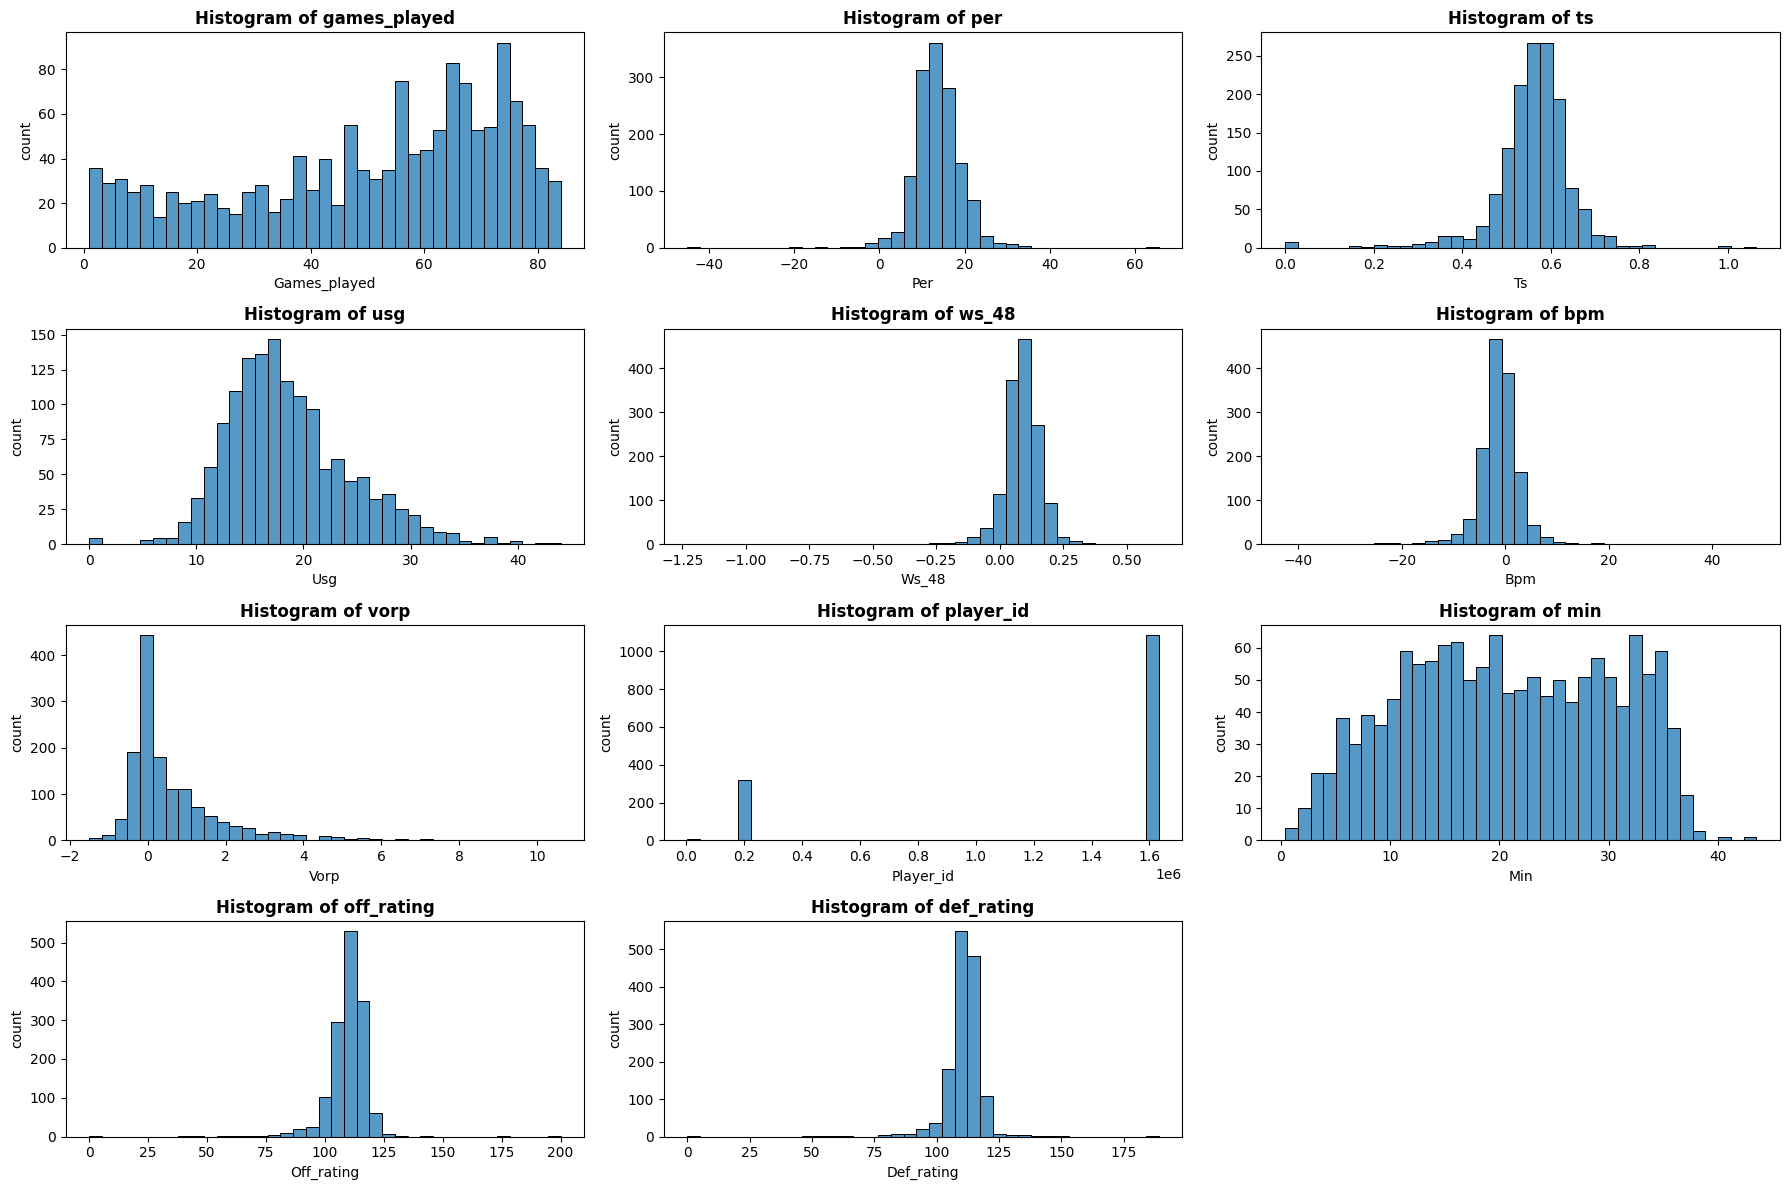

In [283]:
# Histogram of Numeric Variables
num_bins = int(np.sqrt(len(final_df)))

# Define grid size
rows = 4
cols = 3

# Create grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))

# Flatten 2D axes array for easier iteration
axes = axes.flatten()

for i, col in enumerate(numeric_variables):
    sns.histplot(final_df[col], bins=num_bins, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Histogram of {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col.capitalize(), fontsize=10)
    axes[i].set_ylabel('count', fontsize=10)

# Remove empty subplots if any
for i in range(len(numeric_variables), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

**Analysis of Boxplots of Numeric Variables**

- `Games Played`: Thicker box indicates large spread around the median with average 50% of players playing between approximately 38 to 68 games for the season.
- `PER`: Thin box indicates PER scores cluster closely around the median which appears to be slightly below 15. There are a significant number of outliers for both positive and negative PER scores, which is indicative of the database encompassing all calibre of players.
- `TS%`: Thin box suggests true shooting percentage for players centre closely around the median of roughly 0.57. There appears to be significantly more outliers with extremely low true shooting percentage values, indicating the unweighted mean may have been lowered.
- `USG%`: Relatively thick box with 50% of players receiving 15% to 21% of team plays with median value being approximately 17%. There is a significantly greater number of outliers comprised of extremely high usage players, which reflects the large number of superstars that exist within the NBA.
- `WS-48`: Noticeably thin box with median value of approximately 0.1, indicating the average player would likely perform very close to the median value. However, there are significantly more negative outliers than positive ones, likely resulting in the mean being pulled down.
- `BPM`: Noticeably thin box with median value slightly below 0. While there is a large number of both positive and negative outliers, there seems to be slightly more negative outliers and the negative outliers seem to be more significant in value. 
- `VORP`: Relatively thick box with median hovering slightly above 0 at approximately 0.1. The median is much closer to the 1st quartile than the 3rd quartile indicating there are significantly larger gaps in VORP values between an average player and major contributor (e.g. starter) and an average player and minor contributor (e.g. bench player). This is further reinforced by the significant number of positive outliers (e.g. star players).
- `MIN`: Noticeably thick box with median of 20 minutes played per game, suggesting high variance in minutes played among players. Expectedly, no outliers are present.
- `Offensive Rating` and `Defensive Rating`: Both extremely thin boxes with median values of approximately 110 points per 100 possessions. There are significantly more negative outliers present in both statistics, indicating unweighted mean may have been pulled down.

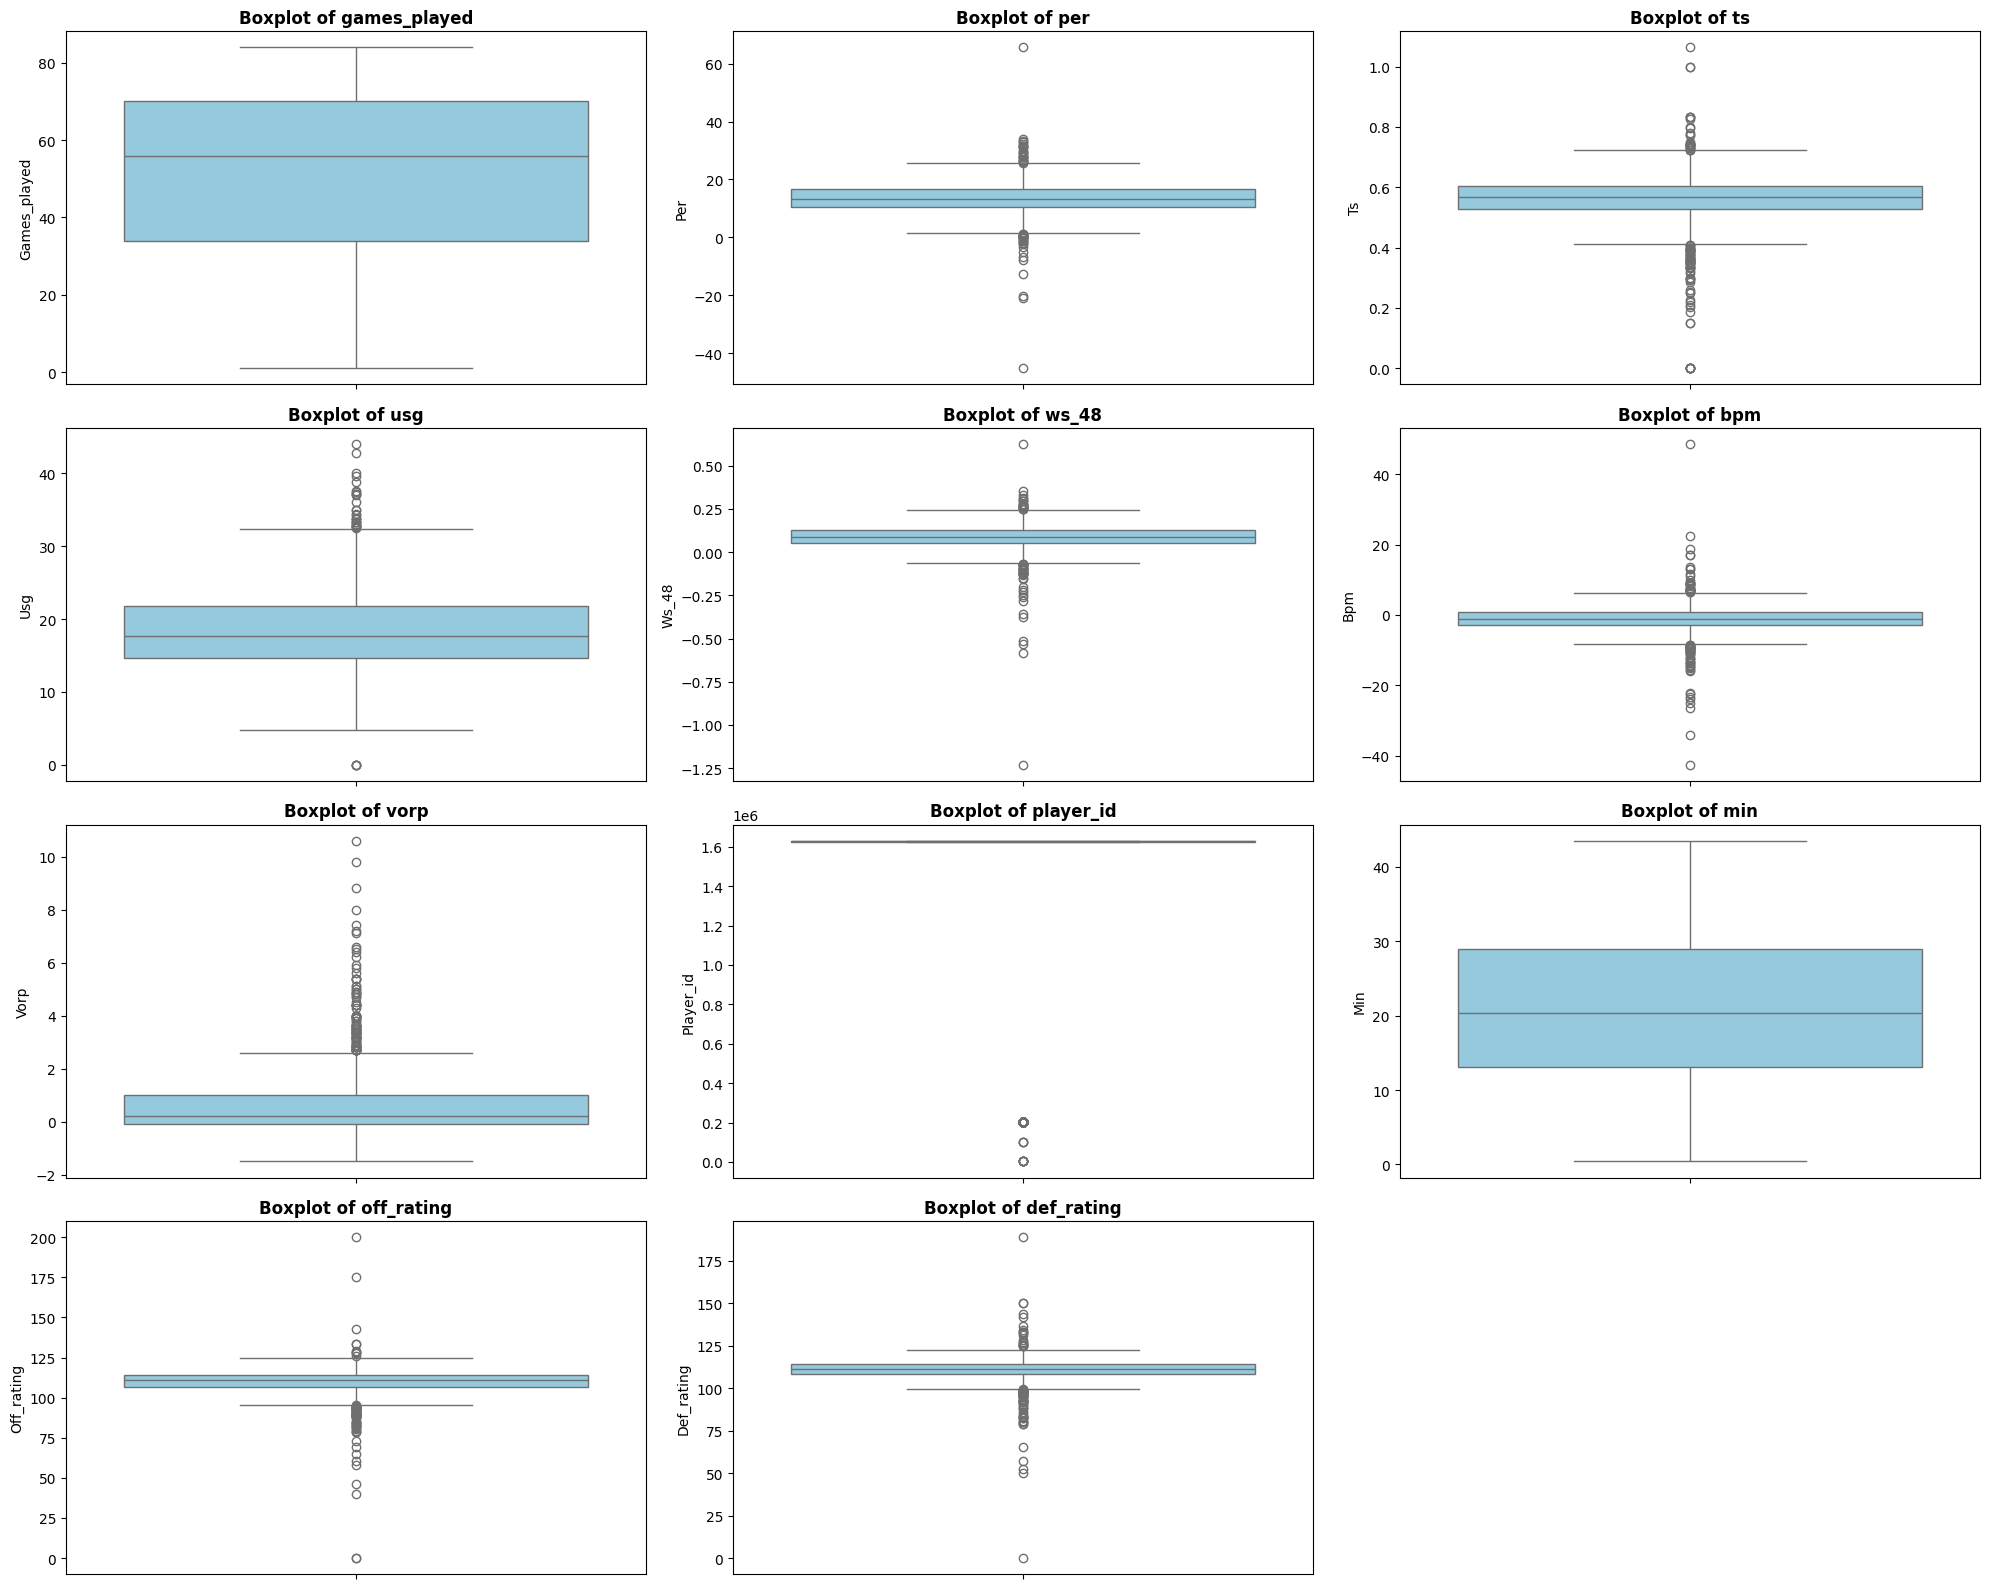

In [284]:
# Define figure size
rows = 4
cols = 3

# Create grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 16))

# Flatten 2D axes array for easier iteration
axes = axes.flatten()

for i, col in enumerate(numeric_variables):
    sns.boxplot(y=final_df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f"Boxplot of {col}", fontsize=12, fontweight='bold')
    axes[i].set_ylabel(col.capitalize(), fontsize=10)

for i in range(len(numeric_variables), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

**Analysis of Bar Charts for Categorical Variables**

Since the dataset includes a large number of nationalities, only the **top 10 most common** have been selected for visualisation. The distribution clearly highlights a significant dominance of **American players**, who make up approximately **76.7%** of the dataset. In contrast, the second most common nationality, **Canadian players**, account for only **4.2%**, revealing a stark discrepancy between the two groups.  

One possible explanation for this gap is that many **foreign players may have only played for a single season** before moving to different leagues. As a result, their records would have been removed from the dataset, contributing to the imbalance observed.  

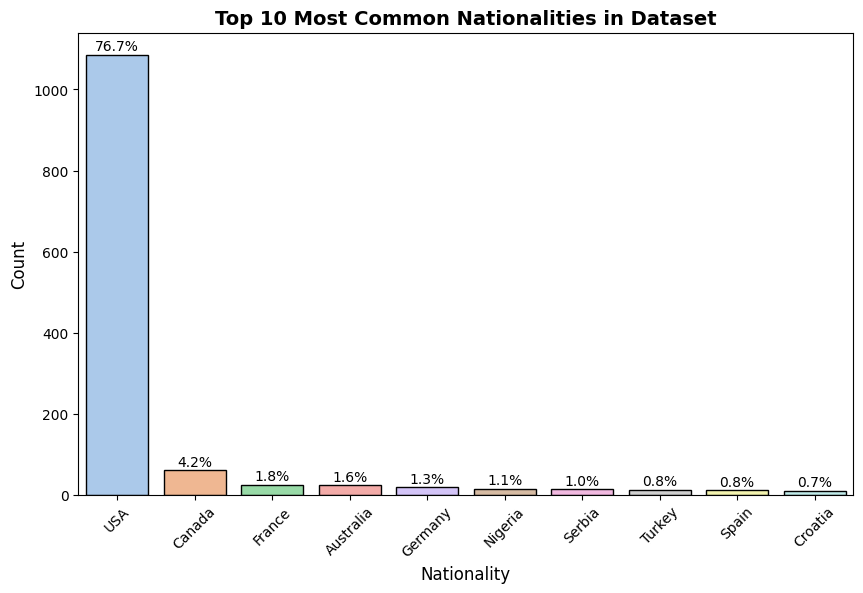

In [285]:
# Obtain 10 most common nationalities
top_n = 10
top_nationalities = final_df['nationality'].value_counts().nlargest(top_n)

# Calculate percentages
total_count = final_df['nationality'].count()
top_nationalities_percentage = (top_nationalities / total_count) * 100

# Define figure size
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=top_nationalities.index,
    y=top_nationalities.values,
    palette='pastel',
    edgecolor='black',
    hue=top_nationalities.index,
    legend=False
)

# Annotate bars with percentage values
for i, value in enumerate(top_nationalities.values):
    percentage = top_nationalities_percentage.iloc[i]
    ax.text(i, value + 10, f"{percentage:.1f}%", ha='center', fontsize=10)

plt.title("Top 10 Most Common Nationalities in Dataset", fontsize=14, fontweight='bold')
plt.xlabel('Nationality', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.show()

The distribution of data across seasons is relatively even, with the 2022-23 season having the highest number of records at approximately 510, while the 2021-22 season has the lowest at around 440.

This fluctuation in player count across seasons is expected, as NBA teams do not have a fixed roster size. Each team can have up to 15 standard contract players, with the option to sign two additional two-way players, bringing the maximum roster size to 17 players.

Since the dataset includes players who have participated in at least two seasons, one possible reason for the higher count in 2022-23 is the presence of players who played in both 2021-22 and 2022-23, as well as those who appeared in 2022-23 and 2023-24, but not necessarily all three seasons. This overlapping effect may have resulted in a higher number of unique player records in the middle season (2022-23) compared to the other two.

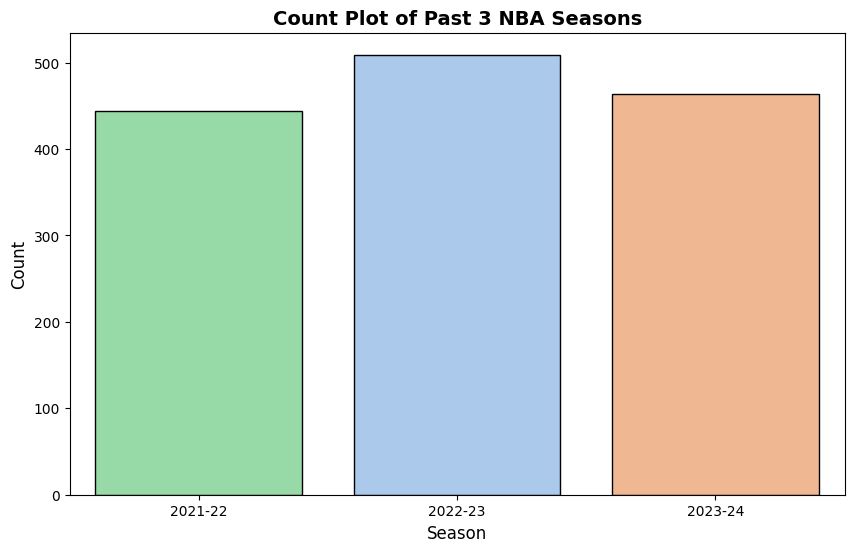

In [286]:
# Ensure seasons are sorted correctly
season_order = ["2021-22", "2022-23", "2023-24"]

plt.figure(figsize=(10, 6))
sns.countplot(data=final_df, x='season', order=season_order, hue='season', legend=False, palette='pastel', edgecolor='black')

plt.title("Count Plot of Past 3 NBA Seasons", fontsize=14, fontweight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

### **Multivariate Analysis: Heatmap of Correlation Coefficients**  

To examine the relationships between numerical variables in the dataset, we use a **heatmap of correlation coefficients**. This visualisation helps identify the strength and direction of associations between different features. By analysing the correlation matrix, we can detect potential linear relationships, multicollinearity, or patterns that may inform further analysis.

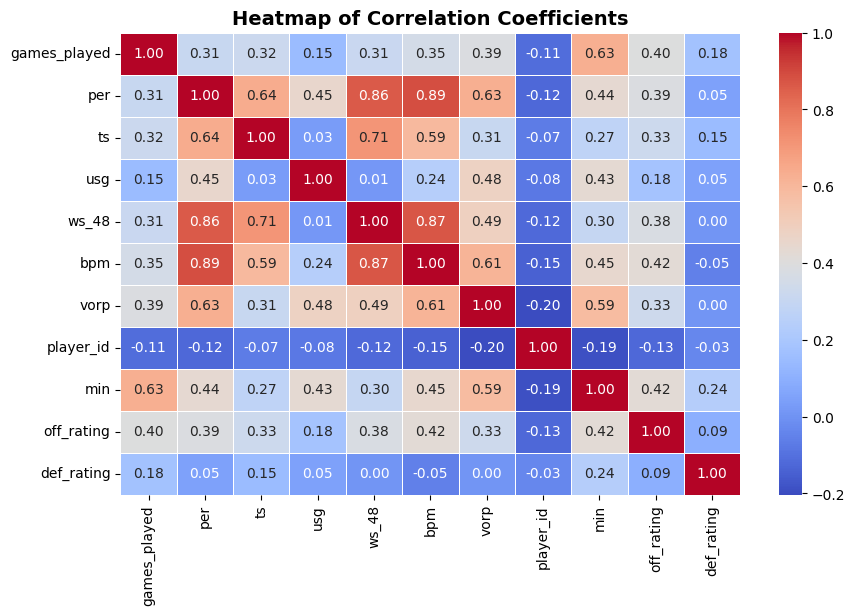

In [287]:
# Define DataFrame with only numeric columns
numeric_df = final_df.select_dtypes(['number'])

# Compute correlation matrix
corr_mat = numeric_df.corr()

# Define figure size
plt.figure(figsize=(10, 6))

# Create heatmap
sns.heatmap(
    corr_mat,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar=True
)

plt.title("Heatmap of Correlation Coefficients", fontsize=14, fontweight="bold")
plt.show()

### **Analysis of Heatmap**

**Key Observations:**

- **Strong Positive Correlations:**  
  The strong correlations between Box Plus-Minus (BPM), Win Shares per 48 Minutes (WS/48), and Player Efficiency Rating (PER) suggest that players with higher efficiency ratings tend to contribute more positively to team success.  
  - `BPM` and `PER` (**0.89**)  
  - `WS/48` and `BPM` (**0.87**)  
  - `WS/48` and `PER` (**0.86**)  
  These relationships are expected since BPM and WS/48 reflect **overall impact**, while PER measures **individual per-minute efficiency**, both of which typically align in high-performing players.

- **Moderate Correlations:**  
  - `Minutes Played per Game (MIN)` shares a moderate positive correlation with Total Games Played (games_played) (0.63) and Value Over Replacement Player (VORP) (0.59).  
  - This suggests that players logging more minutes per game are also more likely to play a higher total number of games across the season and accumulate a higher VORP, a cumulative impact stat.  
  - The positive correlation between VORP and minutes played aligns with expectations, as higher total playing time naturally leads to greater cumulative contributions

- **Weak or No Correlation:**  
  - `Defensive Rating (def_rating)` shows little to no correlation with most other advanced metrics.  
  - Interestingly, `def_rating` even has a slight negative correlation with `BPM` (0.05) suggesting that defensive contributions may not be well captured in other impact metrics.  
  - This raises concerns that offensive performance may be weighted more heavily than defense in standard advanced stats.

### **Key Takeaways & Next Steps:**
✔️ The heatmap indicates that **most advanced statistics are positively correlated with one another, except for Defensive Rating**.  
✔️ This suggests that **offensive statistics may carry more weight** than defensive ones in their computation.  
✔️ **To improve balance in player evaluation**:
  - **Rebalance the weights in the composite score** to **increase the impact of defensive rating**, ensuring that defensive performance is properly rewarded in the final ranking.


## **4. Storing, Filtering, and Retrieving Data**

**Connect** to a PostgreSQL database, **create tables** to store cleaned data, and **execute queries** with filters to retrieve and store data in DataFrames.

### **PostgreSQL-Related Functions**

Define `environment variables` and `functions` necessary to store, filter, and retrieve data from a PostgreSQL database.

In [288]:
# Read environment variables
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

def connect_db():
    """Establishes a connection to the PostgreSQL databse"""
    try:
        conn = psycopg2.connect(
            dbname=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD,
            host=DB_HOST,
            port=DB_PORT
        )
        print("Connection to the database was successful.")
        return conn
    except OperationalError as e:
        print(f"Error: Failed to connect to the PostgreSQL database.\nDetails:{e}")
        return None

def table_exists(cursor, table_name):
    """Checks if a table exists in the PostgreSQL database"""
    query = """
    SELECT EXISTS(
        SELECT FROM information_schema.tables
        WHERE table_name = %s
    );
    """
    cursor.execute(query, (table_name,))
    return cursor.fetchone()[0]


def check_and_create_table(cursor, conn):
    """Checks if the required tables exist and creates them if not"""
    tables = {
        "all_three_seasons": """
            CREATE TABLE all_three_seasons (
                player VARCHAR(50) NOT NULL,
                team VARCHAR(10) NOT NULL,
                games_played INT NOT NULL,
                per FLOAT NOT NULL,
                ts FLOAT NOT NULL,
                usg FLOAT NOT NULL,
                ws_48 FLOAT NOT NULL,
                bpm FLOAT NOT NULL,
                vorp FLOAT NOT NULL,
                season VARCHAR(10) NOT NULL,
                min FLOAT NOT NULL,
                off_rating FLOAT NOT NULL,
                def_rating FLOAT NOT NULL
            );
        """
    }

    for table, create_query in tables.items():
        if not table_exists(cursor, table):
            cursor.execute(create_query)
            conn.commit()
            print(f" Table `{table}` created.")

def load_data(engine):
    """Loads data from CSV files into PostgreSQL database"""
    datasets = {
        "all_three_seasons": "./data/final_df.csv"
    }
    try:
        for table, csv_path in datasets.items():
            df = pd.read_csv(csv_path)
            df.to_sql(table, engine, if_exists="replace", index=False)
            print(f"Data loaded into `{table}`")
    except Exception as e:
        print(f"Failed to load data into `{table}`: {e}")
    
def retrieve_data(engine, query, var_name="DataFrame"):
    """Executes the given SQL query"""
    try:
        with engine.connect() as conn:
            df = pd.read_sql(query, conn)
            print(f"Successfully retrieved data and stored in '{var_name}'")
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None


### **Main Execution**

Leverages the PostgreSQL-related functions to connect to a PSQL database named `nba_players`, creates tables when necessary inside the database, stores csv data within these newly created tables, executes queries to retrieve data user wants, and finally saves the retrieved data as new DataFrames.

The `weighted_query` below obtains the weighted averages of all advanced statistics based on total minutes played **for players that played at least**:
- **15 minutes per game** (one game lasts 48 minutes)
- **41 games played** (one full season is 82 games)
- **2 out of 3 seasons**

 These weighted-averages will be used when computing a composite score to measure the performance of each player across the past 3 seasons to ultimately rank players.

In [289]:
# Main execution
conn = connect_db()

# Define query to obtain weighted averages of all advanced statistics based on total minutes played per season
weighted_query = """
    WITH total_minutes_cte AS(
        SELECT
            *,
            (min * games_played) AS total_minutes
        FROM all_three_seasons
        WHERE                  -- Filter for players that played at least 15 minutes per game and 41 out of 82 games per season
            min >= 15 AND
            games_played >= 41
    )
    SELECT
        player,
        nationality,
        CASE
            WHEN nationality = 'USA' THEN 'USA'
            ELSE 'International'
        END AS player_origin,
        SUM(total_minutes * per) / SUM(total_minutes) AS avg_per,       
        SUM(total_minutes * ts) / SUM(total_minutes) AS avg_ts,       
        SUM(total_minutes * usg) / SUM(total_minutes) AS avg_usg,
        SUM(total_minutes * ws_48) / SUM(total_minutes) AS avg_ws_48,
        SUM(total_minutes * bpm) / SUM(total_minutes) AS avg_bpm,
        SUM(total_minutes * vorp) / SUM(total_minutes) AS avg_vorp,
        SUM(total_minutes * off_rating) / SUM(total_minutes) AS avg_off_rating,
        SUM(total_minutes * def_rating) / SUM(total_minutes) AS avg_def_rating
    FROM total_minutes_cte
    WHERE total_minutes > 0
    GROUP BY player, nationality, player_origin
    HAVING COUNT(DISTINCT season) >= 2
    ORDER BY player
    ;
"""

main_query = """
    WITH player_season_counts AS (
        SELECT 
            player, 
            COUNT(DISTINCT season) AS seasons_played
        FROM all_three_seasons
        WHERE min >= 15 
        AND games_played >= 41
        GROUP BY player
    )
    SELECT 
        a.*,
        CASE 
            WHEN a.nationality = 'USA' THEN 'USA' 
            ELSE 'International' 
        END AS player_origin,
        psc.seasons_played
    FROM all_three_seasons a
    JOIN player_season_counts psc 
        ON a.player = psc.player
    WHERE psc.seasons_played >= 2;
"""

if conn is None:
    print("Connection failed. Exiting...")
    sys.exit

try:
    cursor = conn.cursor()

    # Check and create tables if they do not exist
    check_and_create_table(cursor, conn)

    # Close psycopg2 connection
    cursor.close()
    conn.close()

    # SQLAlchemy connection for efficient data operations
    engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

    # Load data into tables
    load_data(engine)

    # Execute query and store results in DataFrame
    weighted_avg_df = retrieve_data(engine, weighted_query, var_name="weighted_average_df")
    main_df = retrieve_data(engine, main_query, var_name="main_df")

except Exception as e:
    print(f"Unexpected error: {e}")

finally:
    print("Script execution completed.")

Connection to the database was successful.
Data loaded into `all_three_seasons`
Successfully retrieved data and stored in 'weighted_average_df'
Successfully retrieved data and stored in 'main_df'
Script execution completed.


## **5. Ranking Players**

Compute the `composite score` for each player based on **normalised weighted-averages** of advanced statistics to **rank players** that played at least 2 out of the last 3 NBA seasons.

### **Normalisation**

Before calculating the composite score, the weighted-averages must be normalised in order to **prevent large statistics such as PER and BPM from dominating the score**. In other words, normalising the averages ensures fair contribution from all statistics. 

In [290]:
# Normalise advanced statistics
scaler = MinMaxScaler()
metrics = ['per', 'ts', 'usg', 'ws_48', 'bpm', 'vorp', 'off_rating', 'def_rating']
# Create copy to normalise advanced statistics
normalised_main_df = main_df.copy()
normalised_main_df[metrics] = scaler.fit_transform(main_df[metrics])

# Normalise weighted-averages of all advanced statistics
scaler = MinMaxScaler()
avg_metrics = ['avg_per', 'avg_ts', 'avg_usg', 'avg_ws_48', 'avg_bpm', 'avg_vorp', 'avg_off_rating', 'avg_def_rating']
# Create copy to normalise weighted advanced statistics
normalised_avg_df = weighted_avg_df.copy()
normalised_avg_df[avg_metrics] = scaler.fit_transform(weighted_avg_df[avg_metrics])

### **Composite Score**

The **composite score** is constructed by first **normalising** the advanced statistic to ensure consistency across different metrics.  

The **correlation heatmap** reveals that **defensive rating** has little to no correlation with the other seven statistics, which primarily reward offensive contributions. This highlights a key imbalance, as **modern NBA metrics tend to favour offence-focused players.**  

To address this, the composite score is **weighted 70% towards offensive impact** (distributed across the seven offence-oriented metrics) and **30% towards defensive rating**. This **70:30 split** ensures that **defensive effectiveness receives meaningful consideration**, while still reflecting the league’s offensive emphasis. This approach accounts for **both ends of the court** without disproportionately favouring one over the other.

| **Advanced Statistic**         | **Weight (%)** | **Rationale** |
|---------------------------|------------|--------------------------------------------------------------------------|
| Defensive Rating      | 30%        | Balances offensive bias by ensuring defensive impact is strongly considered |
| PER                  | 8%         | Measures overall impact but highly correlated with BPM and WS/48, requiring reduced weight |
| BPM                  | 8%         | Accounts for box score impact but overlaps significantly with PER and WS/48 |
| VORP                 | 8%         | Captures overall value over replacement level but correlates with PER and BPM |
| True Shooting % (TS%) | 11.5%      | Reflects scoring efficiency, an independent metric not tied to counting stats |
| Usage % (USG%)       | 11.5%      | Shows offensive role and involvement, providing unique insight |
| Win Shares per 48 (WS/48) | 11.5%  | Rewards consistent contributions but is highly tied to PER and BPM |
| Offensive Rating      | 11.5%      | Measures offensive efficiency directly, adding a distinct dimension |


In [291]:
# Define weights for each metric
weights = [0.08, 0.115, 0.115, 0.115, 0.08, 0.08, 0.115, 0.3]
main_metric_weight = dict(zip(metrics, weights))
weighted_metric_weight = dict(zip(avg_metrics, weights))

# Calculate composite score for all advanced statistics
main_df["composite_score"] = normalised_main_df[
    list(main_metric_weight.keys())
].mul(main_metric_weight).sum(axis=1)

# Calculate composite score for all weighted statistics
weighted_avg_df["composite_score"] = normalised_avg_df[
    list(weighted_metric_weight.keys())
].mul(weighted_metric_weight).sum(axis=1)

In [292]:
# Create a ranking of all players for each season based on composite score
main_df['rank'] = main_df.groupby(['season'])['composite_score'].rank(method='dense', ascending=False)
main_df['rank'] = main_df['rank'].astype(int)

**Saving the data as csv files**

In [293]:
if not os.path.exists('./data/main_df.csv'):
    main_df.to_csv("./data/main_df.csv", index=False)
if not os.path.exists('./data/weighted_df.csv'):
    weighted_avg_df.to_csv("./data/weighted_df.csv", index=False)

In [294]:
main_df[main_df['player'].str.contains('Giannis')]

,player,team,games_played,per,ts,usg,ws_48,bpm,vorp,season,player_id,min,off_rating,def_rating,nationality,player_origin,seasons_played,composite_score,rank
286,Giannis Antetokounmpo,MIL,67.0,32.1,0.633,34.9,0.281,11.2,7.4,2021-22,203507.0,32.9,115.9,107.9,Greece,International,3,0.790962,2
287,Giannis Antetokounmpo,MIL,63.0,29.0,0.605,38.8,0.204,8.5,5.4,2022-23,203507.0,32.1,116.4,109.2,Greece,International,3,0.771870,5
288,Giannis Antetokounmpo,MIL,73.0,29.9,0.649,33.0,0.246,9.0,7.2,2023-24,203507.0,35.2,119.8,113.2,Greece,International,3,0.795637,4


### **Top 10 Players Over Last 3 NBA Seasons**

In [295]:
weighted_avg_df[['player', 'nationality', 'composite_score']].nlargest(10, 'composite_score')

,player,nationality,composite_score
220,Nikola Jokic,Serbia,0.771837
191,Luka Doncic,Slovenia,0.712931
98,Giannis Antetokounmpo,Greece,0.693213
142,Joel Embiid,Cameroon,0.681159
51,Damian Lillard,USA,0.661997
268,Trae Young,USA,0.651316
253,Shai GilgeousAlexander,Canada,0.640039
77,Domantas Sabonis,Lithuania,0.638985
277,Tyrese Haliburton,USA,0.637385
48,Collin Sexton,USA,0.636888
